In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [2]:
FTSE = pd.read_excel("FTSE_Aug2010_Nov_2023.xlsx", index_col=0, parse_dates=True).sort_index()
# .resample('B').first()
# FTSE = FTSE.ffill()
# b_idx = pd.date_range(FTSE.index[0], FTSE.index[-1], freq='B')
# FTSE.reindex(b_idx).ffill().loc[b_idx]
# FTSE.index = pd.DatetimeIndex(FTSE.index).resample('B').first()

In [3]:
FTSE.head()

,Adj Price
Date,
2010-08-03,5396.48
2010-08-04,5386.16
2010-08-05,5365.78
2010-08-06,5332.39
2010-08-09,5410.52


In [4]:
rtn = 100 * np.log(FTSE/FTSE.shift(1)).dropna()

In [5]:
rtn.head()

,Adj Price
Date,
2010-08-04,-0.191419
2010-08-05,-0.379095
2010-08-06,-0.624221
2010-08-09,1.454566
2010-08-10,-0.632434


In [6]:
# Split training dataset and validation dataset
from sklearn.model_selection import train_test_split
training_set, validation_set = train_test_split(rtn, test_size=0.2, shuffle=False)

<Axes: title={'center': 'FTSE100 return'}, xlabel='Date'>

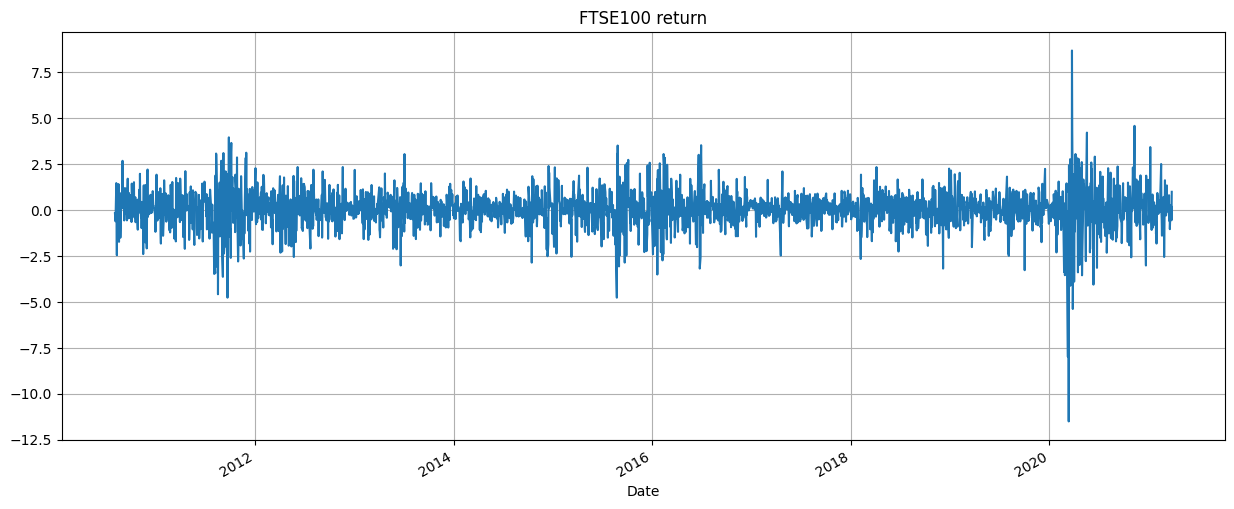

In [9]:
training_set.plot(figsize=(15,6), grid=True, title='FTSE100 return', legend=False)

<Axes: title={'center': 'FTSE100 20 days rolling standard deviation'}, xlabel='Date'>

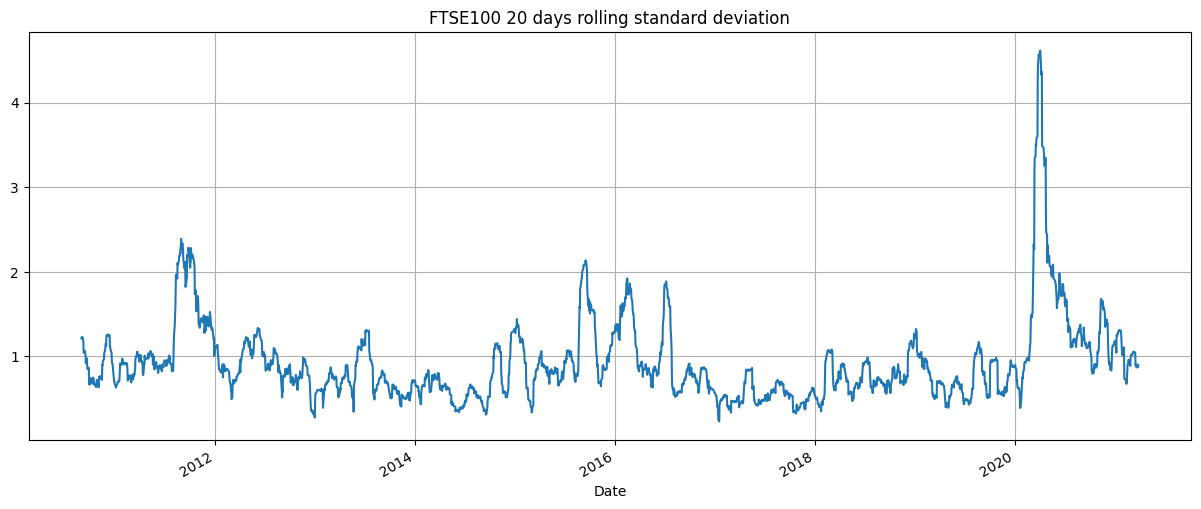

In [11]:
training_set.rolling(20).std().plot(figsize=(15,6), grid=True, title='FTSE100 20 days rolling standard deviation', legend=False)

In [91]:
training_set.head()

,Adj Price
Date,
2010-08-04,-0.191419
2010-08-05,-0.379095
2010-08-06,-0.624221
2010-08-09,1.454566
2010-08-10,-0.632434


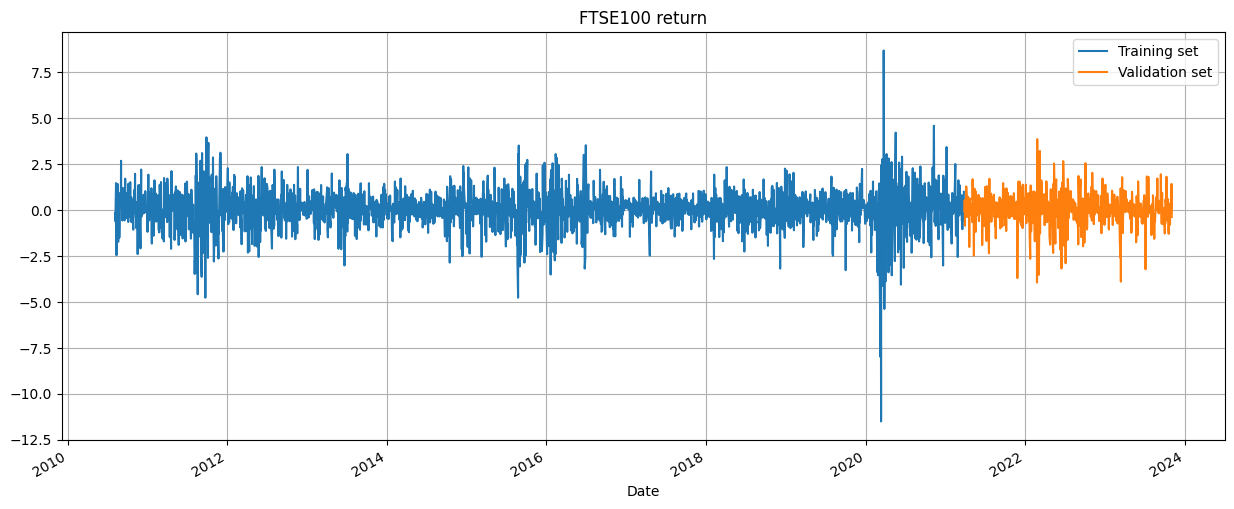

In [17]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15, 6))
training_set.plot(ax=axes, title='FTSE100 return', legend=False)
validation_set['Adj Price'].plot(ax=axes, grid=True)
axes.legend(['Training set', 'Validation set'])

In [18]:
from statsmodels.tsa.stattools import adfuller

def adf_test(timeseries):
    print("Results of Augmented Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)

In [19]:
# step1 test stationary
adf_test(training_set)

Results of Augmented Dickey-Fuller Test:
Test Statistic                  -19.446318
p-value                           0.000000
#Lags Used                        7.000000
Number of Observations Used    2678.000000
Critical Value (1%)              -3.432794
Critical Value (5%)              -2.862620
Critical Value (10%)             -2.567345
dtype: float64


In [20]:
from statsmodels.tsa.stattools import kpss

def kpss_test(timeseries):
    print("Results of KPSS Test:")
    kpsstest = kpss(timeseries, regression="c", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)

In [21]:
# step1 test stationary
kpss_test(training_set)

Results of KPSS Test:
Test Statistic           0.044529
p-value                  0.100000
Lags Used                3.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64


C:\Users\Wei\AppData\Local\Temp\ipykernel_29812\2722398510.py:5: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpsstest = kpss(timeseries, regression="c", nlags="auto")


In [29]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

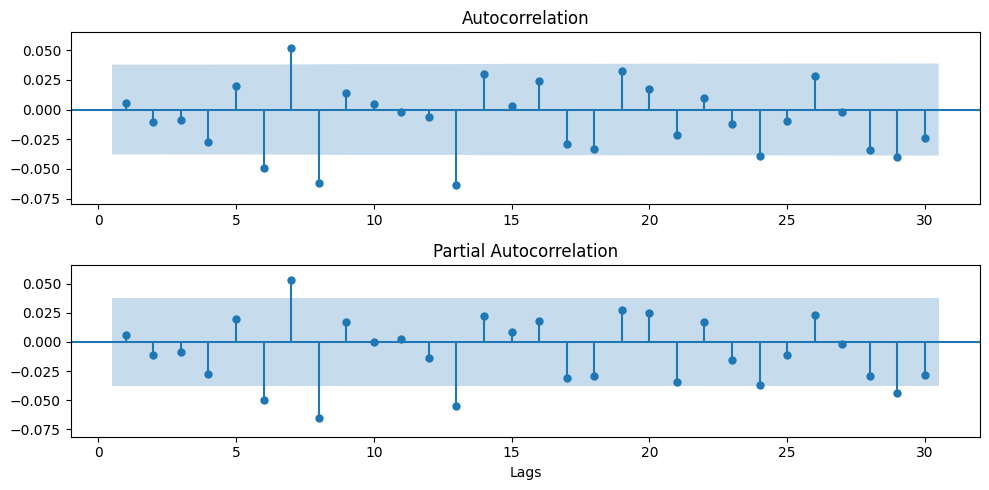

In [30]:
f, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 5))
plot_acf(training_set, lags=30, ax=ax[0], zero=False, auto_ylims=True)
plot_pacf(training_set, lags=30, ax=ax[1], method='ols', zero=False, auto_ylims=True)

# ax[1].annotate('Strong correlation at lag = 1', xy=(1, 0.6),  xycoords='data',
#             xytext=(0.17, 0.75), textcoords='axes fraction',
#             arrowprops=dict(color='red', shrink=0.05, width=1))
ax[1].set_xlabel('Lags')
plt.tight_layout()
plt.show()

In [31]:
acf, ci_acf, qstat_acf, p_acf = sm.tsa.acf(training_set, alpha=0.05, qstat=True)
pacf, ci_pacf = sm.tsa.pacf(training_set, alpha=0.05)
correlogram = np.concatenate((acf[1:].reshape(-1,1), pacf[1:].reshape(-1,1), qstat_acf.reshape(-1,1), p_acf.reshape(-1,1)), axis=1)
correlogram = pd.DataFrame(correlogram, columns=['AC', 'PAC', 'Q-Stat', 'Prob'])
correlogram.index += 1
# step2 test white noise. If not, we need a mean equation.
correlogram.head(20)

,AC,PAC,Q-Stat,Prob
1,0.005827,0.005830,0.091317,0.762509
2,-0.010853,-0.010896,0.408183,0.815388
3,-0.008872,-0.008756,0.620002,0.891838
4,-0.027102,-0.027164,2.597284,0.627304
5,0.019708,0.019881,3.643258,0.601830
6,-0.048777,-0.049858,10.052761,0.122448
7,0.051951,0.052905,17.326507,0.015408
8,-0.062112,-0.065158,27.727385,0.000529
9,0.013818,0.017082,28.242333,0.000869
10,0.004673,0.000094,28.301247,0.001615


In [32]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.api import qqplot

In [33]:
models = {}
ic = []
lag = []
for p in range(7):
    for q in range(7):
        model = ARIMA(training_set, order=(p, 0, q)).fit()
        models['arma('+str(p)+','+str(q)+')'] = model
        ic.append([model.aic, model.bic, model.hqic])
        lag.append((p,q))
    print(p)

c:\Users\Wei\anaconda3\envs\OneDrive\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Wei\anaconda3\envs\OneDrive\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Wei\anaconda3\envs\OneDrive\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Wei\anaconda3\envs\OneDrive\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ign

0


c:\Users\Wei\anaconda3\envs\OneDrive\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Wei\anaconda3\envs\OneDrive\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Wei\anaconda3\envs\OneDrive\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Wei\anaconda3\envs\OneDrive\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ign

1


c:\Users\Wei\anaconda3\envs\OneDrive\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Wei\anaconda3\envs\OneDrive\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Wei\anaconda3\envs\OneDrive\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Wei\anaconda3\envs\OneDrive\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ign

2


c:\Users\Wei\anaconda3\envs\OneDrive\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Wei\anaconda3\envs\OneDrive\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Wei\anaconda3\envs\OneDrive\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Wei\anaconda3\envs\OneDrive\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ign

3


c:\Users\Wei\anaconda3\envs\OneDrive\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Wei\anaconda3\envs\OneDrive\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Wei\anaconda3\envs\OneDrive\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Wei\anaconda3\envs\OneDrive\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ign

4


c:\Users\Wei\anaconda3\envs\OneDrive\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Wei\anaconda3\envs\OneDrive\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Wei\anaconda3\envs\OneDrive\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Wei\anaconda3\envs\OneDrive\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ign

5


c:\Users\Wei\anaconda3\envs\OneDrive\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Wei\anaconda3\envs\OneDrive\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Wei\anaconda3\envs\OneDrive\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Wei\anaconda3\envs\OneDrive\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ign

6


c:\Users\Wei\anaconda3\envs\OneDrive\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [34]:
# step3 using information criterion for choosing the best mean equation
ic = pd.DataFrame(ic, columns=['AIC', 'BIC', 'HQIC'], index=lag)

In [35]:
ic.sort_values(by='AIC').head()

,AIC,BIC,HQIC
"(5, 3)",7803.354103,7862.312187,7824.680744
"(4, 4)",7803.943382,7862.901466,7825.270023
"(3, 4)",7804.105834,7857.168110,7823.299811
"(6, 6)",7804.223237,7886.764554,7834.080534
"(6, 3)",7804.568232,7869.422124,7828.027537


In [36]:
arma_model = models['arma(5,3)']

In [37]:
print(arma_model.summary())

                               SARIMAX Results                                
Dep. Variable:              Adj Price   No. Observations:                 2686
Model:                 ARIMA(5, 0, 3)   Log Likelihood               -3891.677
Date:                Thu, 21 Dec 2023   AIC                           7803.354
Time:                        21:18:17   BIC                           7862.312
Sample:                             0   HQIC                          7824.681
                               - 2686                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0065      0.011      0.565      0.572      -0.016       0.029
ar.L1         -0.5553      0.082     -6.792      0.000      -0.716      -0.395
ar.L2          0.8081      0.029     28.252      0.0

In [38]:
print(arma_model.params)

const     0.006497
ar.L1    -0.555338
ar.L2     0.808118
ar.L3     0.686553
ar.L4    -0.033768
ar.L5     0.044087
ma.L1     0.569415
ma.L2    -0.820678
ma.L3    -0.725984
sigma2    1.062654
dtype: float64


In [39]:
# step4 test arch effect

In [40]:
sm.stats.durbin_watson(arma_model.resid.values)

2.0024551322086754

In [41]:
resid = arma_model.resid

from scipy import stats
stats.normaltest(resid)


NormaltestResult(statistic=766.8412139271693, pvalue=3.0377088588590005e-167)

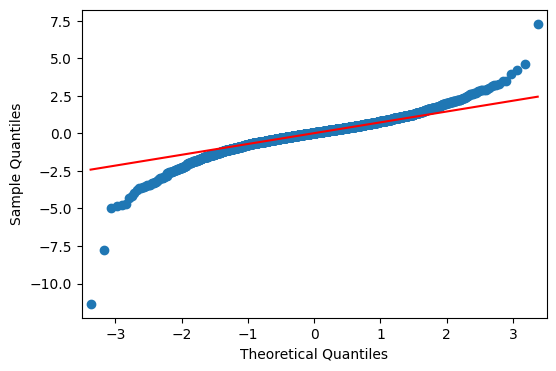

In [42]:
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111)
fig = qqplot(resid, line="q", ax=ax, fit=True)


In [43]:
r, q, p = sm.tsa.acf(resid.values.squeeze(), fft=True, qstat=True)
data = np.c_[np.arange(1, len(r)), r[1:], q, p]

table = pd.DataFrame(data, columns=["lag", "AC", "Q", "Prob(>Q)"])
table.set_index("lag").head(15)

,AC,Q,Prob(>Q)
lag,,,
1.0,-0.001452,0.005672,0.939966
2.0,-0.000833,0.007538,0.996238
3.0,0.009498,0.250276,0.969092
4.0,0.000446,0.250812,0.992764
5.0,-0.017590,1.084011,0.955509
6.0,0.005294,1.159514,0.978837
7.0,0.011411,1.510408,0.981947
8.0,-0.021486,2.754996,0.948780
9.0,-0.002102,2.766918,0.972824


In [44]:
arma_model.tvalues

const      0.565394
ar.L1     -6.792152
ar.L2     28.251957
ar.L3      9.199089
ar.L4     -2.165939
ar.L5      3.194935
ma.L1      7.092099
ma.L2    -33.580609
ma.L3    -10.182762
sigma2    77.886694
dtype: float64

In [45]:
arma_model.params

const     0.006497
ar.L1    -0.555338
ar.L2     0.808118
ar.L3     0.686553
ar.L4    -0.033768
ar.L5     0.044087
ma.L1     0.569415
ma.L2    -0.820678
ma.L3    -0.725984
sigma2    1.062654
dtype: float64

In [46]:
# step4 test arch effect
acf, ci_acf, qstat_acf, p_acf = sm.tsa.acf(resid.values ** 2, alpha=0.05, qstat=True)
pacf, ci_pacf = sm.tsa.pacf(training_set, alpha=0.05)
correlogram = np.concatenate((acf[1:].reshape(-1,1), pacf[1:].reshape(-1,1), qstat_acf.reshape(-1,1), p_acf.reshape(-1,1)), axis=1)
correlogram = pd.DataFrame(correlogram, columns=['AC', 'PAC', 'Q-Stat', 'Prob'])
correlogram.index += 1
correlogram.head(20)

,AC,PAC,Q-Stat,Prob
1,0.150619,0.005830,61.003224,5.698142e-15
2,0.151767,-0.010896,122.962438,1.990883e-27
3,0.354242,-0.008756,460.649331,1.606326e-99
4,0.208582,-0.027164,577.768948,1.002979e-123
5,0.113703,0.019881,612.585208,3.859277e-130
6,0.122975,-0.049858,653.326534,7.274032e-138
7,0.150541,0.052905,714.402706,5.409682e-150
8,0.268656,-0.065158,908.992091,6.489098e-191
9,0.190621,0.017082,1006.992886,5.353524e-211
10,0.128141,0.000094,1051.295067,1.659798e-219


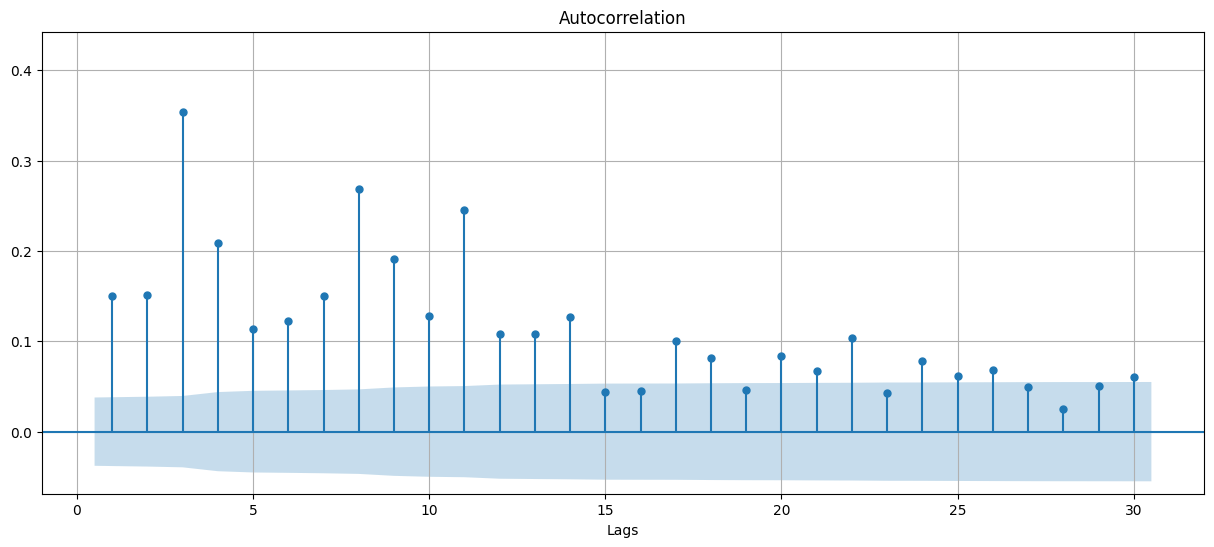

In [54]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 6))
plot_acf(resid.values ** 2, lags=30, ax=ax, zero=False, auto_ylims=True)
# plot_pacf(resid.values ** 2, lags=30, ax=ax[1], method='ols', zero=False, auto_ylims=True)
ax.grid(True)
ax.set_xlabel('Lags')

# plt.tight_layout()
plt.show()

In [73]:
from statsmodels.stats.diagnostic import het_arch

In [78]:
het_arch(resid, store=True, ddof=8)

(582.7184647225563,
 8.867062475216737e-119,
 74.47170476570662,
 7.547911921784101e-135,
 <statsmodels.stats.diagnostic.ResultsStore at 0x1febd2ab710>)

In [79]:
from arch import arch_model

In [85]:
import armagarch as ag

In [88]:
# define mean, vol and distribution
meanMdl = ag.ARMA(order = {'AR':5,'MA':3})
volMdl = ag.garch(order = {'p':1,'q': 1})
distMdl = ag.normalDist()

# create a model
model = ag.empModel(training_set, meanMdl, volMdl, distMdl)
# fit model
model.fit()

c:\Users\Wei\anaconda3\envs\OneDrive\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\Wei\anaconda3\envs\OneDrive\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\Wei\anaconda3\envs\OneDrive\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Wei\anaconda3\envs\OneDrive\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive par

                         ARMA-GARCH estimation results                          
Dep Variable:               Adj Price    R-squared:                       0.01
Mean Model:                      ARMA    Adj. R-squared:                   0.0
Vol Model:                      GARCH    Log Likelihood:               -3463.9
Distribution:                Gaussian    AIC:                           6951.8
Method:                            ML    BIC:                          7022.55
                                         Num obs:                         2686
Date:                Thu, Dec 21 2023    Df Residuals:                    2675
Time:                        00:36:27    Df Model:                          11
                                                                                
                                   Mean Model                                   
                            Estimate          Std. Error              t-stat
------------------------------------------------

In [90]:
print(model.summary())

                         ARMA-GARCH estimation results                          
Dep Variable:               Adj Price    R-squared:                       0.01
Mean Model:                      ARMA    Adj. R-squared:                   0.0
Vol Model:                      GARCH    Log Likelihood:               -3463.9
Distribution:                Gaussian    AIC:                           6951.8
Method:                            ML    BIC:                          7022.55
                                         Num obs:                         2686
Date:                Thu, Dec 21 2023    Df Residuals:                    2675
Time:                        00:37:02    Df Model:                          11
                                                                                
                                   Mean Model                                   
                            Estimate          Std. Error              t-stat
------------------------------------------------

In [ ]:
ag.

<Axes: xlabel='Date'>

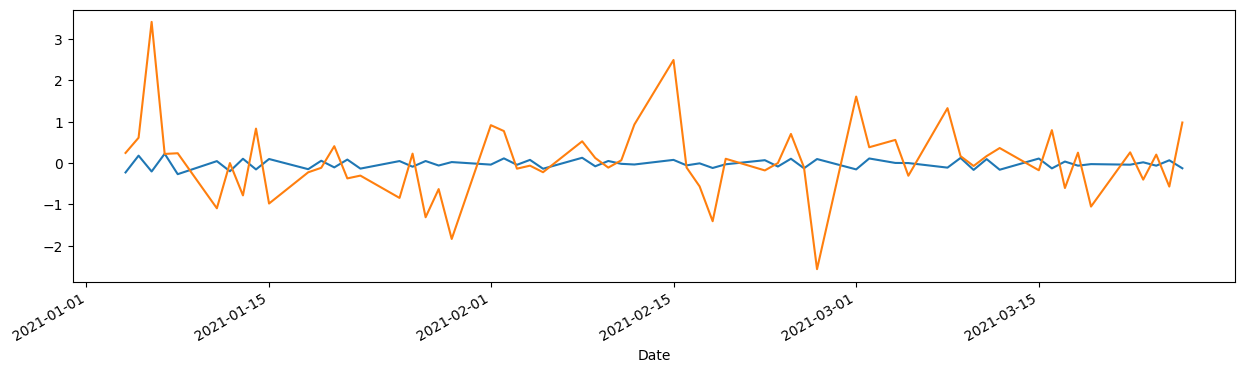

In [64]:
arma_model.predict()['2021'].plot(figsize=(15,4))
training_set.loc['2021', 'Adj Price'].plot()

In [65]:
training_set.tail()

,Adj Price
Date,
2021-03-22,0.258880
2021-03-23,-0.400886
2021-03-24,0.204294
2021-03-25,-0.568582
2021-03-26,0.980372


In [66]:
forecast = arma_model.get_prediction(start=-50, dynamic=True)
yhat = forecast.predicted_mean
yhat_conf_int = forecast.conf_int(alpha=0.05)

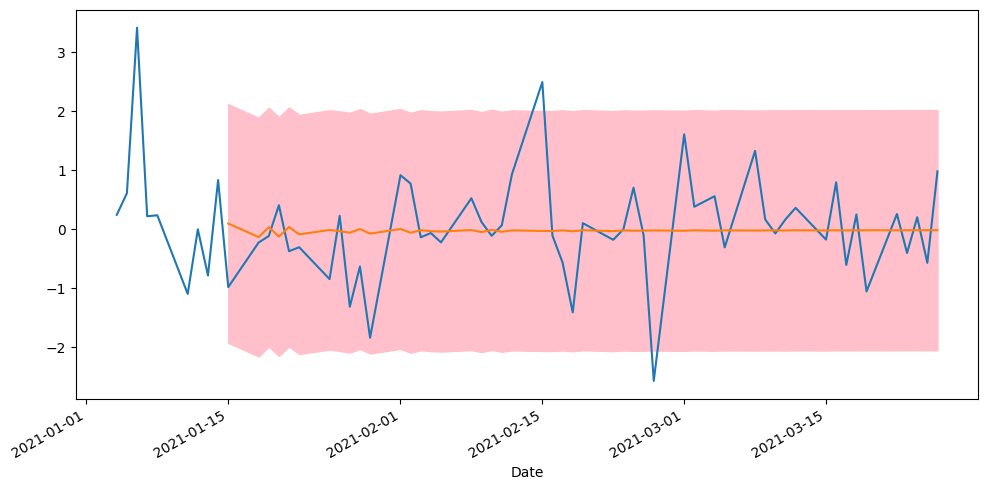

In [67]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))
training_set.loc['2021', 'Adj Price'].plot(ax=ax)
yhat.plot(ax=ax)

ax.fill_between(yhat_conf_int.index, yhat_conf_int['lower Adj Price'], yhat_conf_int['upper Adj Price'], color='pink') 
plt.tight_layout()
plt.show()

In [68]:
yhat

Date
2021-01-15    0.097981
2021-01-18   -0.133016
2021-01-19    0.035126
2021-01-20   -0.122017
2021-01-21    0.038577
2021-01-22   -0.086774
2021-01-25   -0.011131
2021-01-26   -0.031461
2021-01-27   -0.057453
2021-01-28    0.003798
2021-01-29   -0.073260
2021-02-01    0.005207
2021-02-02   -0.058607
2021-02-03   -0.015876
2021-02-04   -0.032001
2021-02-05   -0.038374
2021-02-08   -0.012915
2021-02-09   -0.047530
2021-02-10   -0.009679
2021-02-11   -0.041689
2021-02-12   -0.018231
2021-02-15   -0.028848
2021-02-16   -0.028775
2021-02-17   -0.018541
2021-02-18   -0.033658
2021-02-19   -0.015549
2021-02-22   -0.031267
2021-02-23   -0.018626
2021-02-24   -0.024953
2021-02-25   -0.023293
2021-02-26   -0.019320
2021-03-01   -0.025648
2021-03-02   -0.017012
2021-03-04   -0.024529
2021-03-05   -0.017782
2021-03-08   -0.021286
2021-03-09   -0.019619
2021-03-10   -0.018109
2021-03-11   -0.020565
2021-03-12   -0.016421
2021-03-15   -0.019882
2021-03-16   -0.016275
2021-03-17   -0.018080
2021-0

In [310]:
yhat_conf_int['upper Adj Price'] - yhat_conf_int['lower Adj Price']

Date
2021-01-15    4.043401
2021-01-18    4.043915
2021-01-19    4.044719
2021-01-20    4.045008
2021-01-21    4.045684
2021-01-22    4.048769
2021-01-25    4.053478
2021-01-26    4.057832
2021-01-27    4.060456
2021-01-28    4.061331
2021-01-29    4.061374
2021-02-01    4.061549
2021-02-02    4.062256
2021-02-03    4.063295
2021-02-04    4.064230
2021-02-05    4.064778
2021-02-08    4.064952
2021-02-09    4.064957
2021-02-10    4.065002
2021-02-11    4.065164
2021-02-12    4.065393
2021-02-15    4.065594
2021-02-16    4.065709
2021-02-17    4.065743
2021-02-18    4.065743
2021-02-19    4.065755
2021-02-22    4.065792
2021-02-23    4.065842
2021-02-24    4.065885
2021-02-25    4.065909
2021-02-26    4.065916
2021-03-01    4.065916
2021-03-02    4.065919
2021-03-04    4.065927
2021-03-05    4.065938
2021-03-08    4.065947
2021-03-09    4.065952
2021-03-10    4.065954
2021-03-11    4.065954
2021-03-12    4.065954
2021-03-15    4.065956
2021-03-16    4.065959
2021-03-17    4.065961
2021-0

In [311]:
yhat_conf_int['lower Adj Price']

Date
2021-01-15   -1.871068
2021-01-18   -2.120093
2021-01-19   -1.935995
2021-01-20   -2.105046
2021-01-21   -1.930752
2021-01-22   -2.078089
2021-01-25   -1.985739
2021-01-26   -2.023432
2021-01-27   -2.043592
2021-01-28   -1.985105
2021-01-29   -2.064974
2021-02-01   -1.983689
2021-02-02   -2.051060
2021-02-03   -2.008930
2021-02-04   -2.024298
2021-02-05   -2.034823
2021-02-08   -2.006410
2021-02-09   -2.044120
2021-02-10   -2.006257
2021-02-11   -2.037113
2021-02-12   -2.018059
2021-02-15   -2.024331
2021-02-16   -2.029842
2021-02-17   -2.016107
2021-02-18   -2.033895
2021-02-19   -2.016276
2021-02-22   -2.030413
2021-02-23   -2.021840
2021-02-24   -2.024377
2021-02-25   -2.027243
2021-02-26   -2.020624
2021-03-01   -2.029007
2021-03-02   -2.020816
2021-03-04   -2.027291
2021-03-05   -2.023449
2021-03-08   -2.024457
2021-03-09   -2.025933
2021-03-10   -2.022751
2021-03-11   -2.026698
2021-03-12   -2.022893
2021-03-15   -2.025856
2021-03-16   -2.024140
2021-03-17   -2.024530
2021-0

In [58]:
res = pd.read_csv('res.csv')

In [59]:
import seaborn as sb

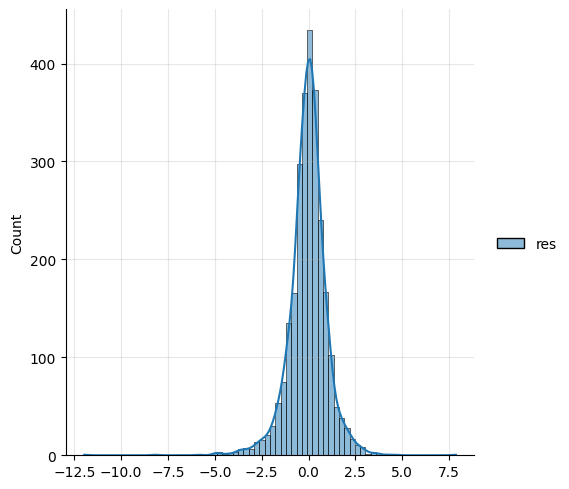

In [71]:

sb.displot(res, kde=True,bins=70)
plt.grid(True, alpha = 0.3)

In [73]:
forecast = pd.read_csv('forecase.csv', index_col=0, parse_dates=True)

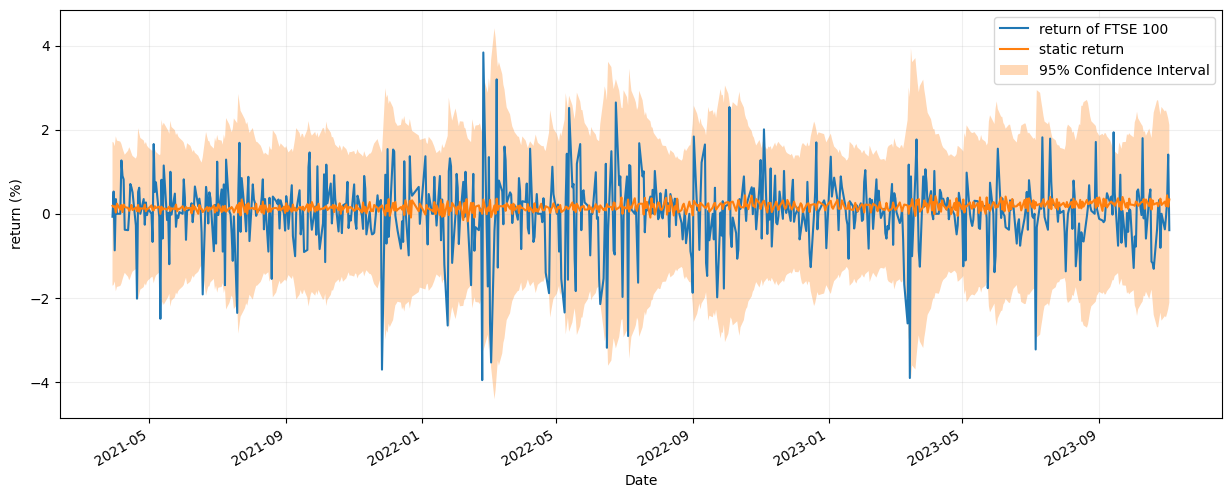

In [94]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 6))
forecast['return'].plot(ax = ax)
forecast['static_mean'].plot(ax = ax)
ax.fill_between(forecast.index, forecast['static_low'], forecast['static_up'], facecolor ='tab:orange', alpha = 0.3)
ax.grid(alpha = 0.2)
ax.set_ylabel('return (%)')
ax.legend(['return of FTSE 100','static return', '95% Confidence Interval'])

In [80]:
forecast.columns

Index(['static_mean', 'dynamic_mean', 'static_sigma', 'dynamic_sigma',
       'return', 'static_low', 'static_up', 'dynamic_low', 'dynamic_up'],
      dtype='object')

In [82]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 6))
forecast['return'].plot(ax = ax)
forecast['dynamic_mean'].plot(ax = ax)
ax.fill_between(forecast.index, forecast['dynamic_low'], forecast['dynamic_up'], facecolor ='tab:orange', alpha = 0.3)
ax.grid(alpha = 0.2)
ax.set_ylabel('return (%)')
ax.legend(['return of FTSE 100','dynamic return', '95% Confidence Interval'])

KeyError: 'static_high'